In [1]:
import pandas as pd
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
import random
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, losses, activations, regularizers, metrics, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import backend as K
from sklearn.utils import class_weight

2024-12-01 14:34:47.437140: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-01 14:34:48.093803: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
# going to create classes in the folders that have the image data, and then crate a function that will move the images to the corresponding folder
train_class_folders = [os.path.join("CNN_Train", chr(letter)) for letter in range(65, 91)]  # creating 26 folders in the 'CNN_Train' folder; the names of each folder are the letters of the alphabet
test_class_folders =  [os.path.join("CNN_Test", chr(letter)) for letter in range(65, 91)]  #  creating 26 folders in the 'CNN_Test' folder; the names of each folder are the letters of the alphabe

# defining the function that will move the images
def move_images(folder_path, class_folders):
    files = os.listdir(folder_path) # getting all the image names in the directory and storing those under the variable named "files"
    
    for filename in files: # iterating through the image names
        if filename.endswith('.jpg'):  # Going to process only .jpg files (there was a singular csv file in the directory so want to ignore that)
            first_letter = filename[0].upper()  # Geting the first letter of the image name so we can properply classify it into its corresponding class
            
            if 'A' <= first_letter <= 'Z':  # Ensure it's between A and Z 
                class_index = ord(first_letter) - ord('A')  # Convert A-Z to index 0-25
                class_folder = class_folders[class_index]
                
                # Ensure that the class folder exists; if not, create it
                if not os.path.exists(class_folder):
                    os.makedirs(class_folder)
                    print(f"Created directory: {class_folder}") 
                
                old_file_path = os.path.join(folder_path, filename)
                new_file_path = os.path.join(class_folder, filename)
                
                shutil.move(old_file_path, new_file_path)
                print(f"Moved '{filename}' to '{class_folder}'.")

# Move images to the appropriate class folders
move_images("CNN_Train", train_class_folders)
move_images("CNN_Test", test_class_folders)


In [11]:
# moving the validation images into their correct folder
validation_class_folders =  [os.path.join("CNN_Validation", chr(letter)) for letter in range(65, 91)]  #  creating 26 folders in the 'CNN_Validation' folder; the names of each folder are the letters of the alphabe
move_images("CNN_Validation", validation_class_folders)

Created directory: CNN_Validation/O
Moved 'O8_jpg.rf.509f42d956f0aea772ad8bd5bae63911.jpg' to 'CNN_Validation/O'.
Moved 'O0_jpg.rf.023d580ccbb5070164655cf7821c68cd.jpg' to 'CNN_Validation/O'.
Created directory: CNN_Validation/F
Moved 'F4_jpg.rf.6c4f597db5c59ae128b19e56e3aa726b.jpg' to 'CNN_Validation/F'.
Created directory: CNN_Validation/K
Moved 'K0_jpg.rf.5701395c0f48d9781464c1a1e7c48ee0.jpg' to 'CNN_Validation/K'.
Created directory: CNN_Validation/I
Moved 'I13_jpg.rf.c32c078b577f7727b8c2949cd2195d00.jpg' to 'CNN_Validation/I'.
Created directory: CNN_Validation/P
Moved 'P17_jpg.rf.b4929ef5847009ff2708159f02ce8562.jpg' to 'CNN_Validation/P'.
Moved 'P2_jpg.rf.8ba235abbfdbc8b0c5e52f7a72ebff9f.jpg' to 'CNN_Validation/P'.
Moved 'O11_jpg.rf.37d2a88c110bbbb430020119e51dfc50.jpg' to 'CNN_Validation/O'.
Moved 'O22_jpg.rf.89b14d5285d9ee7865810c7fb4156082.jpg' to 'CNN_Validation/O'.
Created directory: CNN_Validation/B
Moved 'B12_jpg.rf.cb6e9aaaa48880c87cc76866bbf41ba7.jpg' to 'CNN_Validation/B'.

In [2]:
# now we are going to read in the dataset
# source - https://www.tensorflow.org/tutorials/load_data/images
training_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'CNN_Train', # the folder we are reading from; in this case we are reading from 'CNN_Train'
    image_size = (374,374), # the image size
    batch_size = 1512, # the number of images
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'CNN_Validation', # the folder we are reading from; in this case we are reading from 'CNN_Validation'
    image_size = (374,374), # the image size
    batch_size = 144, # the number of images
)
testing_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'CNN_Test', # the folder we are reading from; in this case we are reading from 'CNN_Test'
    image_size = (374,374), # the image size
    batch_size = 72, # the number of images
)


train_class_names = training_dataset.class_names
print(train_class_names) # okay perfect we see that the there are class names and even better they correspond to each letter
validation_class_names = validation_dataset.class_names
print(validation_class_names)
test_class_names = testing_dataset.class_names
print(test_class_names) # we see that the testing set is missing two letters - the letter e and l; this could be a problem moving forward with the code so we should be mindful of this

Found 1512 files belonging to 26 classes.
Found 144 files belonging to 26 classes.
Found 93 files belonging to 26 classes.
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


2024-12-01 14:35:26.154499: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31013 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0


Displaying random images from the training dataset classes:


2024-11-22 12:21:59.243335: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2537910144 exceeds 10% of free system memory.


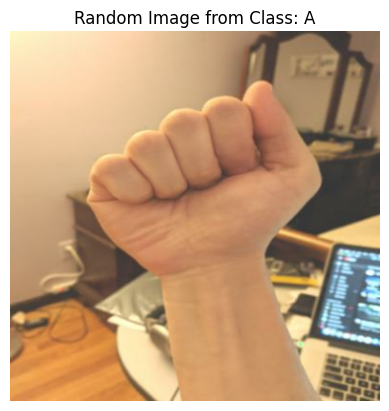

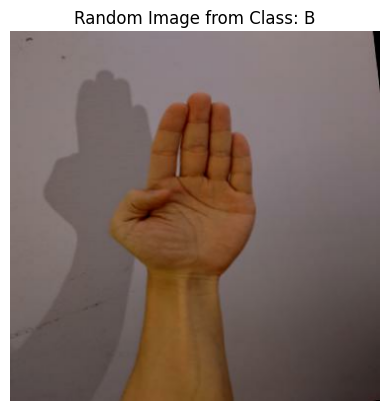

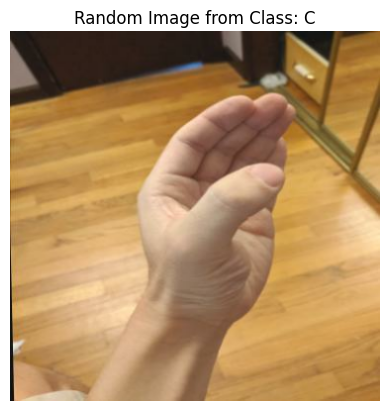

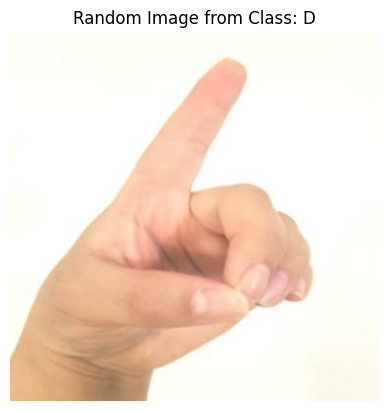

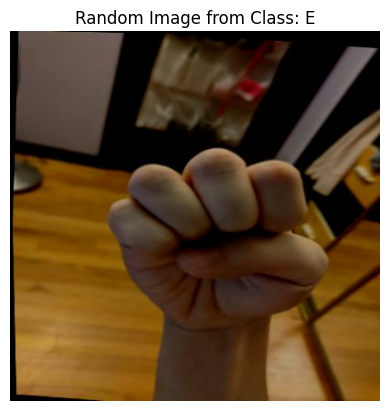

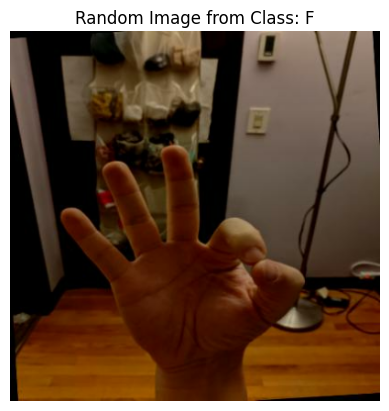

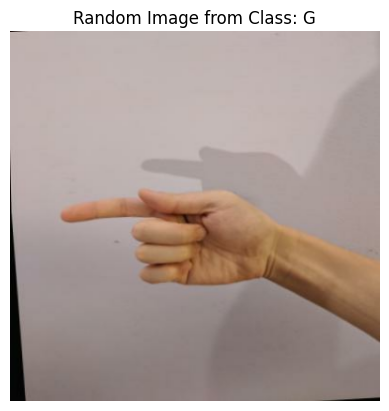

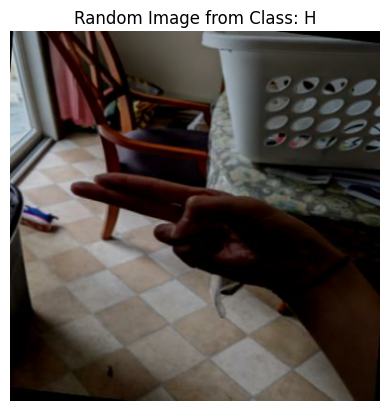

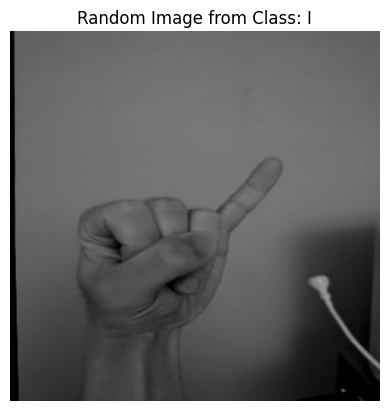

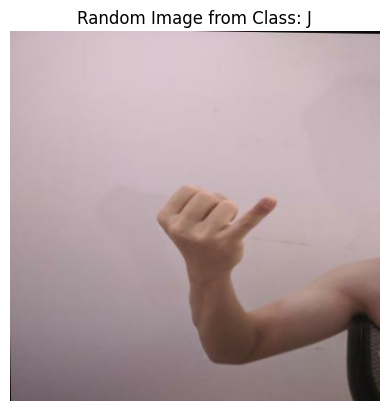

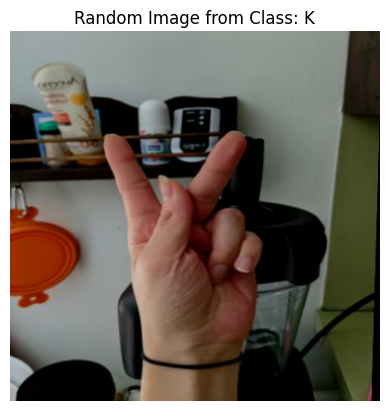

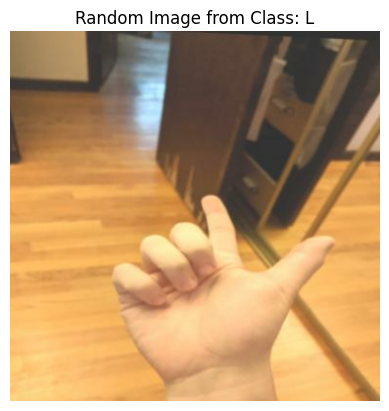

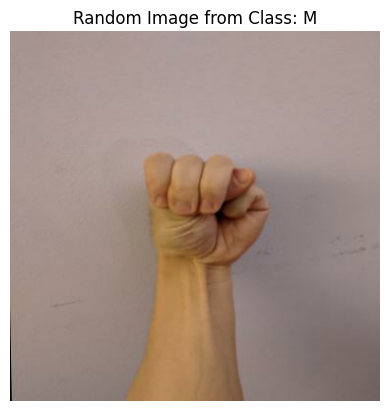

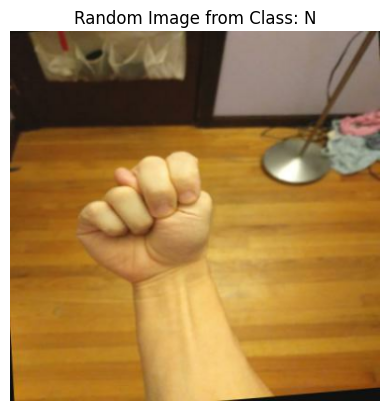

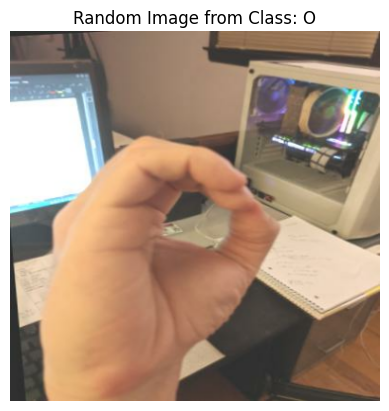

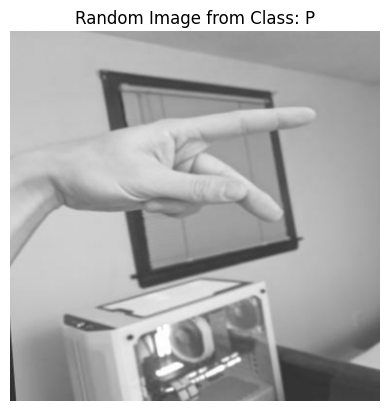

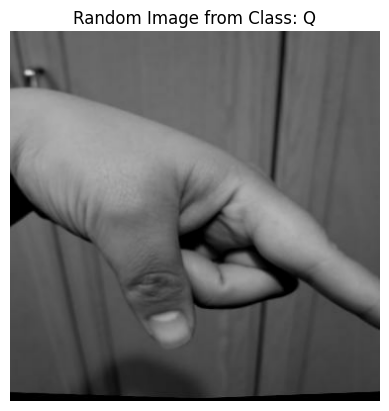

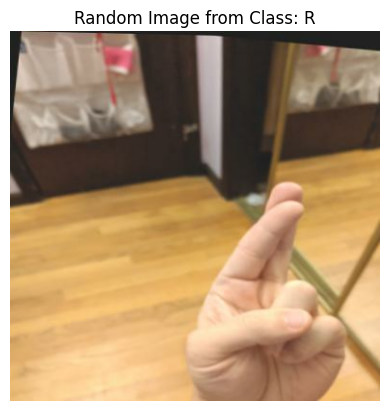

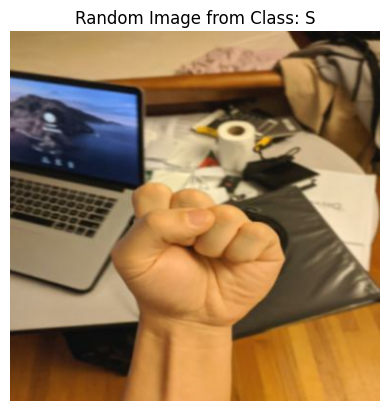

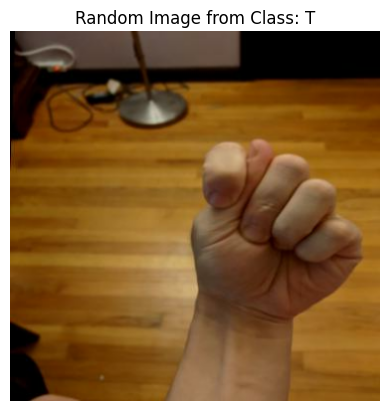

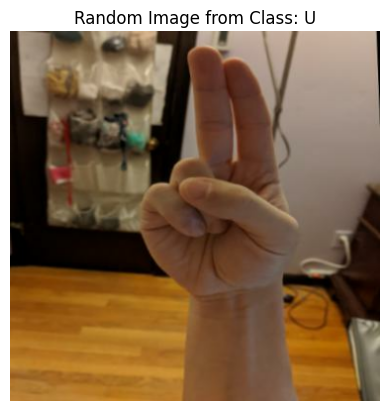

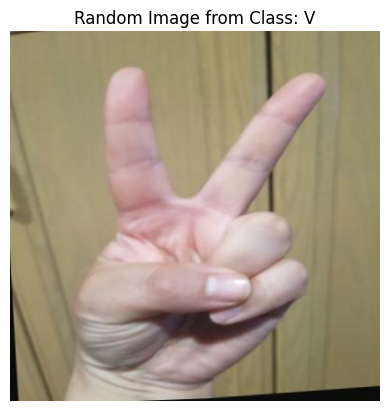

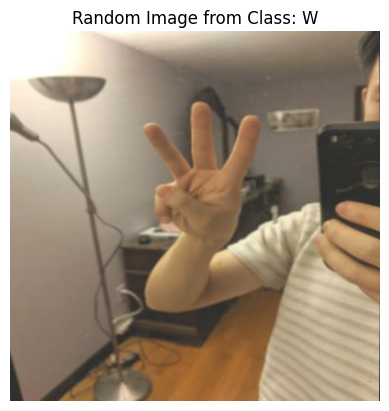

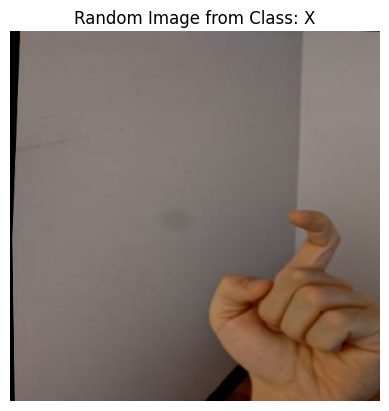

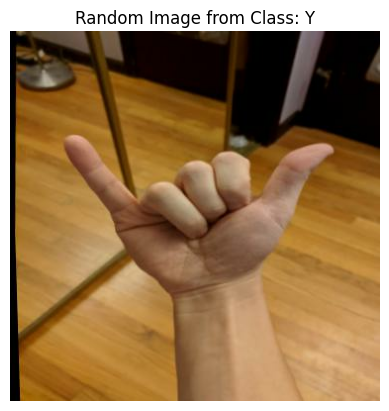

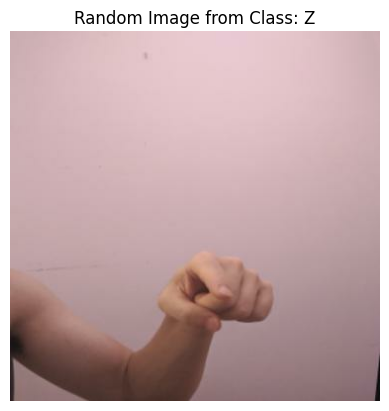

In [8]:
# Function to display random images from each class in a given dataset
def display_random_image_from_each_class(dataset, class_names):
    # Convert dataset to a list of image batches and corresponding labels
    image_batches = list(dataset.as_numpy_iterator())
    
    # Display random image for each class
    for class_index, class_name in enumerate(class_names):
        # Find all images corresponding to the current class
        class_images = []
        class_labels = []
        
        for images, labels in image_batches:
            # Get the images and labels for the current class
            mask = labels == class_index
            class_images.append(images[mask])
            class_labels.append(labels[mask])
        
        class_images = np.concatenate(class_images, axis=0)  # All images for the current class
        
        # Pick a random image from the class
        random_image = class_images[np.random.choice(class_images.shape[0])]
        
        # Display the image
        plt.imshow(random_image.astype("uint8"))
        plt.title(f"Random Image from Class: {class_name}")
        plt.axis("off")  # Hide axis
        plt.show()

# Call the function for training dataset
print("Displaying random images from the training dataset classes:")
display_random_image_from_each_class(training_dataset, training_dataset.class_names)

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# first need to remove the additional class named checkpoints:
import os
import shutil
# Function to remove .ipynb_checkpoints directories 
def remove_checkpoints(directory):
    for root, dirs, files in os.walk(directory):
        for dir_name in dirs:
            if dir_name == ".ipynb_checkpoints":
                shutil.rmtree(os.path.join(root, dir_name))

# Remove checkpoints from the training and test directories
remove_checkpoints('CNN_Train')
remove_checkpoints('CNN_Test')
remove_checkpoints('CNN_Valid')

# Define the image data generators for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Rescale pixel values to [0, 1]
    horizontal_flip=True,       # Randomly flip images horizontally
    fill_mode='nearest'         # Fill missing pixels after transformations
)

test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for test set

# Create generators for training, validation, and testing
train_generator = train_datagen.flow_from_directory(
    'CNN_Train',               # Path to training data
    target_size=(224, 224),     # Resize images to match ResNet50 input size
    batch_size=32,              # Batch size
    class_mode='categorical',   # Use categorical labels (multi-class)
    subset= 'training' 
)

validation_generator = test_datagen.flow_from_directory(
    'CNN_Validation',               # Path to validation data
    target_size=(224, 224),
   batch_size=32,
    class_mode='categorical',
)

test_generator = test_datagen.flow_from_directory(
    'CNN_Test',                # Path to test data
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
)
class_names = list(train_generator.class_indices.keys())
print("Class names:", class_names)
test_class_names = list(test_generator.class_indices.keys())
print("Class names:", test_class_names) # missing the letter l 
validation_class_names = list(validation_generator.class_indices.keys())
print("Class names:", validation_class_names) 


Found 1512 images belonging to 26 classes.
Found 144 images belonging to 26 classes.
Found 93 images belonging to 26 classes.
Class names: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Class names: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Class names: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [4]:
#definning our CNN model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam

# Loading the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freezing the base layers to prevent retraining
for layer in base_model.layers:
    layer.trainable = False

# Build the custom classification model
def build_model():
    # Input layer
    input_layer = layers.Input(shape=(224, 224, 3))
    
    # Base ResNet50 model
    x = base_model(input_layer)
    
    # Add Global Average Pooling layer
    x = layers.GlobalAveragePooling2D()(x)
    
    # Add a fully connected layer with 26 units for A-Z letters
    x = layers.Dense(256, activation='relu')(x)
    
    # Output layer with 26 units and softmax activation
    output_layer = layers.Dense(26, activation='softmax')(x)
    print(output_layer)
    # Create the model
    model = models.Model(inputs=input_layer, outputs=output_layer)
    
    return model

# Build the model
model = build_model()
# Print the model summary to check the architecture
model.summary()

# Compile the model with Adam optimizer and categorical cross-entropy loss; how fast it updates the matrix ; the closer to zero the faster its learning
model.compile(optimizer=Adam(learning_rate = 0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 26), dtype=tf.float32, name=None), name='dense_1/Softmax:0', description="created by layer 'dense_1'")
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 26)                6682      
                                            

In [5]:
# Calculating the class weights
train_labels = train_generator.classes  # getting the 26 classes from the train class and storing it under the variable train_labels
class_weights = class_weight.compute_class_weight(
    'balanced', 
    classes=np.unique(train_labels), 
    y=train_labels
)
# Applying the augmentation to the training data
train_generator = train_datagen.flow_from_directory(
    'CNN_Train',  
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 1512 images belonging to 26 classes.


In [6]:

history = model.fit(
    train_generator,  # Training data generator
    steps_per_epoch=train_generator.samples // train_generator.batch_size,  # Number of steps per epoch
    epochs=700,  # Number of epochs
    validation_data=validation_generator,  # Validation data generator
    class_weight={i: weight for i, weight in enumerate(class_weights)},  # Passing computed class weights
    validation_steps=validation_generator.samples // validation_generator.batch_size  # Steps for validation data
)

# After training, evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)

# Print the test accuracy
print(f'Test accuracy: {test_acc}')
# okay so with 500 epochs and weighted it was caping out at around 60% accurate

Epoch 1/700


2024-12-01 14:36:06.992195: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2024-12-01 14:36:09.050758: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f13b5012d50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-01 14:36:09.050786: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2024-12-01 14:36:09.161496: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-01 14:36:09.988516: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


47/47 [==============================] - 15s 198ms/step - loss: 3.3318 - accuracy: 0.0406 - val_loss: 3.2581 - val_accuracy: 0.0469
Epoch 2/700
47/47 [==============================] - 3s 60ms/step - loss: 3.2784 - accuracy: 0.0358 - val_loss: 3.2911 - val_accuracy: 0.0547
Epoch 3/700
47/47 [==============================] - 3s 56ms/step - loss: 3.2731 - accuracy: 0.0459 - val_loss: 3.2816 - val_accuracy: 0.0469
Epoch 4/700
47/47 [==============================] - 3s 54ms/step - loss: 3.2482 - accuracy: 0.0703 - val_loss: 3.2560 - val_accuracy: 0.0391
Epoch 5/700
47/47 [==============================] - 3s 55ms/step - loss: 3.2435 - accuracy: 0.0561 - val_loss: 3.2735 - val_accuracy: 0.0703
Epoch 6/700
47/47 [==============================] - 3s 58ms/step - loss: 3.2348 - accuracy: 0.0615 - val_loss: 3.2634 - val_accuracy: 0.0469
Epoch 7/700
47/47 [==============================] - 3s 57ms/step - loss: 3.2206 - accuracy: 0.0736 - val_loss: 3.2159 - val_accuracy: 0.0391
Epoch 8/700
47/4

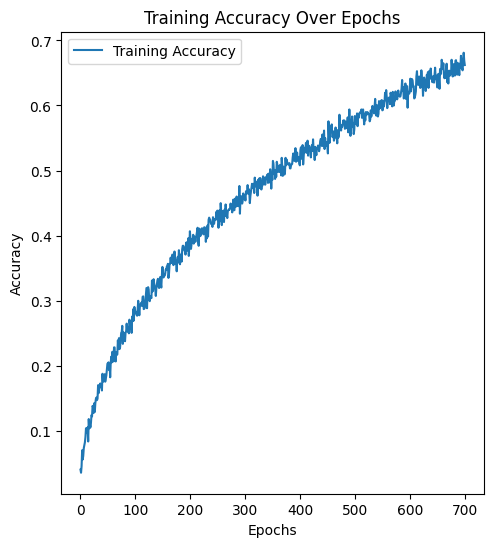

In [7]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()    #plotting the training accuracy

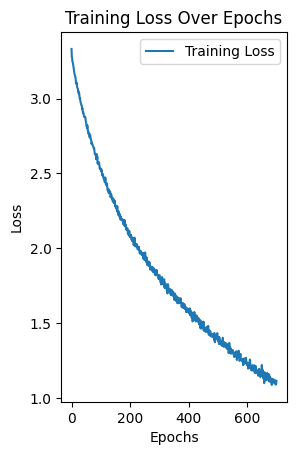

In [8]:
#plotting the training loss 

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [9]:
from sklearn.metrics import classification_report
import numpy as np

for i in range(26):
    # Predict on the test set
    y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Get true labels
    y_true = test_generator.classes

    # Define the index of the missing class (letter 'L')
    missing_class_idx = train_generator.class_indices['L']

    # Get class names for the test set
    test_classes = list(test_generator.class_indices.keys())

    # Get all indices for the valid classes (excluding 'L')
    valid_classes = [i for i in range(len(train_generator.class_indices)) if i != missing_class_idx]

    # Print classification report for all classes excluding the missing one
    
print(classification_report(y_true, y_pred_classes, target_names=test_classes, labels=valid_classes,digits = 10))

# for 750 pictures it is still only learning 4 letters; going to attempt to continue refining the model

3/3 [==============================] - 0s 46ms/step
              precision    recall  f1-score   support

           A  0.0000000000 0.0000000000 0.0000000000         1
           B  0.0000000000 0.0000000000 0.0000000000         3
           C  0.3333333333 0.2500000000 0.2857142857         4
           D  0.0000000000 0.0000000000 0.0000000000         1
           E  0.2000000000 0.1333333333 0.1600000000        15
           F  0.0000000000 0.0000000000 0.0000000000         2
           G  0.0000000000 0.0000000000 0.0000000000         5
           H  0.0000000000 0.0000000000 0.0000000000         3
           I  0.0000000000 0.0000000000 0.0000000000         2
           J  0.0000000000 0.0000000000 0.0000000000         4
           K  0.0000000000 0.0000000000 0.0000000000         4
           L  0.0000000000 0.0000000000 0.0000000000         3
           M  0.0000000000 0.0000000000 0.0000000000         3
           N  0.1111111111 0.3333333333 0.1666666667         3
           

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2326: UserWarning: labels size, 25, does not match size of target_names, 26
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `ze